In [1]:
from spice.models.binary import Binary, add_orbit, evaluate_orbit_at_times
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

In [2]:
def default_icosphere(radius=1):
    return get_mesh_view(IcosphereModel.construct(1000, radius, 1., [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))

body1 = default_icosphere()
body2 = default_icosphere(0.5)
binary = Binary.from_bodies(body1, body2)
binary = add_orbit(binary, 1., 0., 0., 0., 0., 0., 10, 0., 0., 20)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


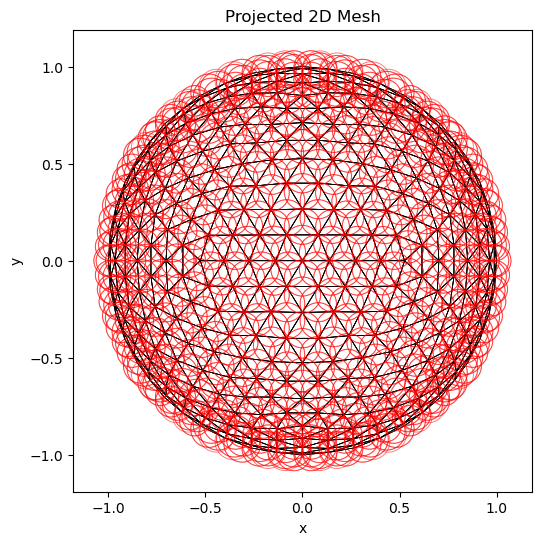

In [3]:
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(6, 6))

# Get 2D projected vertices and faces for body1
verts2d = body1.cast_vertices  # shape (n_vertices, 2)
faces = body1.faces.astype(int)  # shape (n_faces, 3)

# Build list of polygons for PolyCollection
polys = [verts2d[face] for face in faces]

mesh = PolyCollection(polys, edgecolor='k', facecolor='none', linewidth=0.5)
ax.add_collection(mesh)

# Plot the cast_vertex_bounding_circle_radii as a scatter plot on top of the mesh
radii = body1.cast_vertex_bounding_circle_radii
cast_centers = body1.cast_centers  # shape (n_vertices, 2)
for center, radius in zip(cast_centers, radii):
    # Ensure center and radius are Python floats, not JAX arrays
    center_np = np.asarray(center).astype(float)
    radius_np = float(np.asarray(radius))
    circle = plt.Circle(center_np, radius_np, color='r', fill=False, alpha=0.5, linewidth=0.7)
    ax.add_patch(circle)


ax.autoscale()
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Projected 2D Mesh')
plt.show()


In [4]:
binary.n_neighbours1, binary.n_neighbours2

(Array(5, dtype=int32, weak_type=True), Array(33, dtype=int32, weak_type=True))

In [5]:
times = jnp.linspace(0.15706372, 0.1598338, 5)
pb1, pb2 = evaluate_orbit_at_times(binary, times)

In [6]:
times[13]

Array(0.1598338, dtype=float32)

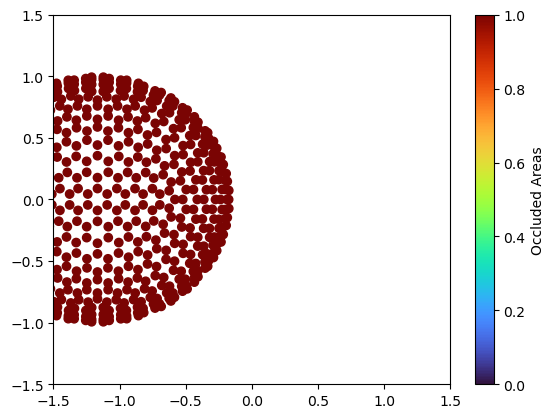

In [7]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

all_visible_cast_areas = jnp.concatenate([pb1[i].visible_cast_areas[pb1[i].mus > 0] / pb1[i].cast_areas[pb1[i].mus > 0] for i in range(len(times))])

sc = ax.scatter(pb1[0].cast_centers[pb1[0].mus > 0, 0], pb1[0].cast_centers[pb1[0].mus > 0, 1],
                c=pb1[0].visible_cast_areas[pb1[0].mus > 0] / pb1[0].cast_areas[pb1[0].mus > 0], cmap='turbo')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Occluded Areas')
sc.set_clim(vmin=all_visible_cast_areas.min(), vmax=all_visible_cast_areas.max())

def update(i):
    sc.set_offsets(pb1[i].cast_centers[pb1[i].mus > 0, :])
    sc.set_array(pb1[i].visible_cast_areas[pb1[i].mus > 0] / pb1[i].cast_areas[pb1[i].mus > 0])
    return sc,

ani = FuncAnimation(fig, update, frames=len(times), interval=500, blit=True)
plt.show()
ani.save('occlusion_debugging.gif')